# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/data'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

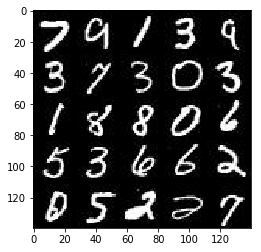

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

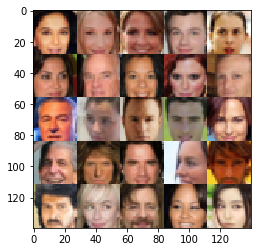

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,
        (None, image_width, image_height, image_channels),
        name='input_real')
    input_z = tf.placeholder(tf.float32,
        (None, z_dim),
        name='input_z')
    learn_rate = tf.placeholder(tf.float32,
        name='learn_rate')

    return (input_real, input_z, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Zero-centered Normal distribution weights initializer
def w_init(stddev=0.02):
    return tf.random_normal_initializer(stddev=stddev)

In [7]:
import numpy as np

def discriminator(images, reuse=False, alpha=0.2, prnt=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    conv_depth = [32, 64, 128, 256] # [64, 128, 256]
    conv_ksize = [3, 5, 5, 5]
    with tf.variable_scope('discriminator', reuse=reuse):
        '''
        tf.layers.conv2d(inputs, filters, kernel_size, strides=(1, 1), padding='valid', ...
        '''
       
        # CONV 1
        conv_1 = tf.layers.conv2d(
            images, conv_depth[0], conv_ksize[0], strides=1, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_1 = tf.layers.batch_normalization(conv_1, training=True) # Batchnorm
        conv_1 = tf.maximum(alpha * conv_1, conv_1) # Leaky_ReLU
        if prnt: print('CONV 1: {}'.format(conv_1.get_shape().as_list()))
        
        # CONV 2
        conv_2 =  tf.layers.conv2d(
            conv_1, conv_depth[1], conv_ksize[1], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_2 = tf.layers.batch_normalization(conv_2, training=True) # Batchnorm
        conv_2 = tf.maximum(alpha * conv_2, conv_2) # Leaky_ReLU
        if prnt: print('CONV 2: {}'.format(conv_2.get_shape().as_list()))
        
        # CONV 3
        conv_3 =  tf.layers.conv2d(
            conv_2, conv_depth[2], conv_ksize[2], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_3 = tf.layers.batch_normalization(conv_3, training=True) # Batchnorm
        conv_3 = tf.maximum(alpha * conv_3, conv_3) # Leaky_ReLU
        if prnt: print('CONV 3: {}'.format(conv_3.get_shape().as_list()))
        
        # CONV 4
        conv_4 =  tf.layers.conv2d(
            conv_3, conv_depth[3], conv_ksize[3], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_4 = tf.layers.batch_normalization(conv_4, training=True) # Batchnorm
        conv_4 = tf.maximum(alpha * conv_4, conv_4) # Leaky_ReLU
        if prnt: print('CONV 4: {}'.format(conv_4.get_shape().as_list()))
        
        # Logits and Output
        logits = tf.reshape(conv_4, (-1, np.prod(conv_4.get_shape().as_list()[1:]))) # Flatten
        logits = tf.layers.dense(logits, 1,
            kernel_initializer=w_init()) # Fully connected layer
        output = tf.sigmoid(logits) # Sigmoid activation for classification
        if prnt: print('Output: {}'.format(output.get_shape().as_list()))
        
    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

CONV 1: [None, 28, 28, 32]
CONV 2: [None, 14, 14, 64]
CONV 3: [None, 7, 7, 128]
CONV 4: [None, 4, 4, 256]
Output: [None, 1]
CONV 1: [None, 28, 28, 32]
CONV 2: [None, 14, 14, 64]
CONV 3: [None, 7, 7, 128]
CONV 4: [None, 4, 4, 256]
Output: [None, 1]
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, img_size=28, prnt=False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    conv_depth = [128, 64, 32, out_channel_dim]
    conv_ksize = [5, 5, 5, 3]
    
    with tf.variable_scope('generator', reuse=not is_train):
        '''
        tf.layers.conv2d_transpose(inputs, filters, kernel_size, strides=(1, 1), padding='valid', ...
        '''
        # Fully connected layer
        dim = [4, 256]
        layer_0 = tf.layers.dense(z, dim[0]**2*dim[1], kernel_initializer=w_init())
        layer_0 = tf.reshape(layer_0, (-1, dim[0], dim[0], dim[1])) # First 'feature' stack
        layer_0 = tf.layers.batch_normalization(layer_0, training=is_train) # Batchnorm
        layer_0 =  tf.maximum(alpha * layer_0, layer_0) # Leaky_ReLU
        if prnt: print('FC Layer 0: {}'.format(layer_0.get_shape().as_list()))
        
        # CONV_T 0
        conv_0 = tf.layers.conv2d_transpose(
            layer_0, conv_depth[0], conv_ksize[0], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_0 = tf.layers.batch_normalization(conv_0, training=is_train) # Batchnorm
        conv_0 = tf.maximum(alpha * conv_0, conv_0) # Leaky_ReLU
        if prnt: print('CONV_T 0: {}'.format(conv_0.get_shape().as_list()))
        
        # CONV_T 1
        conv_1 = tf.layers.conv2d_transpose(
            conv_0, conv_depth[1], conv_ksize[1], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_1 = tf.layers.batch_normalization(conv_1, training=is_train) # Batchnorm
        conv_1 = tf.maximum(alpha * conv_1, conv_1) # Leaky_ReLU
        if prnt: print('CONV_T 1: {}'.format(conv_1.get_shape().as_list()))
        
        # CONV_T 2
        conv_2 = tf.layers.conv2d_transpose(
            conv_1, conv_depth[2], conv_ksize[2], strides=2, padding='same',
            kernel_initializer=w_init()) # Convolution
        conv_2 = tf.layers.batch_normalization(conv_2, training=is_train) # Batchnorm
        conv_2 = tf.maximum(alpha * conv_2, conv_2) # Leaky_ReLU
        if prnt: print('CONV_T 2: {}'.format(conv_2.get_shape().as_list()))
        
        # CONV_T 3
        conv_3 = tf.layers.conv2d_transpose(
            conv_2, conv_depth[3], conv_ksize[3], strides=1, padding='same',
            kernel_initializer=w_init()) # Convolution
        if prnt: print('CONV_T 3: {}'.format(conv_3.get_shape().as_list()))
        
        # Crop
        crop = tf.slice(conv_3, [0,2,2,0], [-1,28,28,-1])
        if prnt: print('Crop : {}'.format(crop.get_shape().as_list()))
                
        # Output
        output = tf.tanh(crop) # 
        if prnt: print('Output: {}'.format(output.get_shape().as_list()))    
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

tests.test_generator(generator, tf)

FC Layer 0: [None, 4, 4, 256]
CONV_T 0: [None, 8, 8, 128]
CONV_T 1: [None, 16, 16, 64]
CONV_T 2: [None, 32, 32, 32]
CONV_T 3: [None, 32, 32, 5]
Crop : [None, 28, 28, 5]
Output: [None, 28, 28, 5]
FC Layer 0: [None, 4, 4, 256]
CONV_T 0: [None, 8, 8, 128]
CONV_T 1: [None, 16, 16, 64]
CONV_T 2: [None, 32, 32, 32]
CONV_T 3: [None, 32, 32, 5]
Crop : [None, 28, 28, 5]
Output: [None, 28, 28, 5]
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Modified version of 'model_loss()' in DCGAN lesson
    g_model = generator(input_z, out_channel_dim) # Generator output
    d_model_real, d_logits_real = discriminator(input_real) # Discriminator output with real images
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True) # Discriminator output with generator images

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits( # Logits: Yes | Labels: Yes
            logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits( # Logits: No  | Labels: No
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss      = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits( # Logits: No  | Labels: Yes
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake # Combine loss for real and fake inputs
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Modified version of 'model_opt()' in DCGAN lesson
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize and update tf.layers.batch_normalization layers population statistics
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`
- `show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
!mkdir checkpoints

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, n_files):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    
    # Create TF Placeholders for the Neural Network
    input_real, input_z, learn_rate = model_inputs(
        image_width=data_shape[1],
        image_height=data_shape[2],
        image_channels=data_shape[3],
        z_dim=z_dim)
    
    # Adjust input_real range from (-0.5,0.5) -> (-1.0,1.0)
    input_real = tf.multiply(input_real, 2)
    
    # Build the GANs for training and calculate the loss
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim=data_shape[3])
    
    # Create the optimization operations for the GANs
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    # Model saver  
    saver = tf.train.Saver()
    
    print_every = 1000 // batch_size
    show_every = 10000 // batch_size
    losses = []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_num, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                c = 2 # Tip from slack. Give the generator more tries to find good activations
                batch_z = np.random.uniform(-1, 1, size=(batch_size * c, z_dim))
                
                # Run optimizers
                _ = sess.run(
                    d_train_opt,
                    feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(
                    g_train_opt,
                    feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Step {}...".format(steps),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{}...".format(batch_num, n_files // batch_size),
                          "D Loss: {:.4f}...".format(train_loss_d),
                          "G Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 15... Epoch 1/2... Batch 14/937... D Loss: 0.1834... G Loss: 2.3912
Step 30... Epoch 1/2... Batch 29/937... D Loss: 0.1271... G Loss: 5.0066
Step 45... Epoch 1/2... Batch 44/937... D Loss: 0.6942... G Loss: 1.1312
Step 60... Epoch 1/2... Batch 59/937... D Loss: 0.6488... G Loss: 0.9684
Step 75... Epoch 1/2... Batch 74/937... D Loss: 0.6502... G Loss: 1.4471
Step 90... Epoch 1/2... Batch 89/937... D Loss: 0.2371... G Loss: 2.5962
Step 105... Epoch 1/2... Batch 104/937... D Loss: 0.1697... G Loss: 3.0388
Step 120... Epoch 1/2... Batch 119/937... D Loss: 0.1262... G Loss: 3.1671
Step 135... Epoch 1/2... Batch 134/937... D Loss: 0.1515... G Loss: 4.4391
Step 150... Epoch 1/2... Batch 149/937... D Loss: 0.0660... G Loss: 3.6121


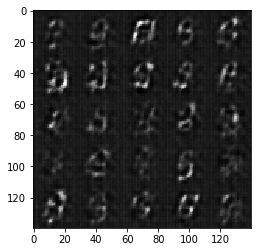

Step 165... Epoch 1/2... Batch 164/937... D Loss: 0.0356... G Loss: 4.2701
Step 180... Epoch 1/2... Batch 179/937... D Loss: 0.0304... G Loss: 4.2345
Step 195... Epoch 1/2... Batch 194/937... D Loss: 0.0249... G Loss: 4.3792
Step 210... Epoch 1/2... Batch 209/937... D Loss: 0.0544... G Loss: 3.7583
Step 225... Epoch 1/2... Batch 224/937... D Loss: 0.0633... G Loss: 4.8308
Step 240... Epoch 1/2... Batch 239/937... D Loss: 0.2519... G Loss: 2.4977
Step 255... Epoch 1/2... Batch 254/937... D Loss: 0.0402... G Loss: 6.9970
Step 270... Epoch 1/2... Batch 269/937... D Loss: 0.1471... G Loss: 2.6854
Step 285... Epoch 1/2... Batch 284/937... D Loss: 0.3447... G Loss: 1.5199
Step 300... Epoch 1/2... Batch 299/937... D Loss: 0.3325... G Loss: 3.9427


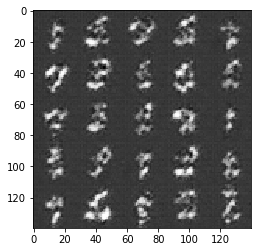

Step 315... Epoch 1/2... Batch 314/937... D Loss: 0.0819... G Loss: 3.5622
Step 330... Epoch 1/2... Batch 329/937... D Loss: 0.1313... G Loss: 3.4936
Step 345... Epoch 1/2... Batch 344/937... D Loss: 0.4483... G Loss: 3.5438
Step 360... Epoch 1/2... Batch 359/937... D Loss: 0.1640... G Loss: 3.3616
Step 375... Epoch 1/2... Batch 374/937... D Loss: 0.0888... G Loss: 3.7622
Step 390... Epoch 1/2... Batch 389/937... D Loss: 0.1515... G Loss: 2.3375
Step 405... Epoch 1/2... Batch 404/937... D Loss: 0.0461... G Loss: 3.7678
Step 420... Epoch 1/2... Batch 419/937... D Loss: 0.0194... G Loss: 5.5508
Step 435... Epoch 1/2... Batch 434/937... D Loss: 0.0476... G Loss: 3.8678
Step 450... Epoch 1/2... Batch 449/937... D Loss: 0.0235... G Loss: 4.6727
Step 465... Epoch 1/2... Batch 464/937... D Loss: 0.0346... G Loss: 4.6268


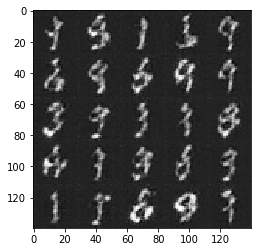

Step 480... Epoch 1/2... Batch 479/937... D Loss: 0.0310... G Loss: 4.3339
Step 495... Epoch 1/2... Batch 494/937... D Loss: 0.0698... G Loss: 3.2898
Step 510... Epoch 1/2... Batch 509/937... D Loss: 0.5783... G Loss: 1.9391
Step 525... Epoch 1/2... Batch 524/937... D Loss: 0.3772... G Loss: 2.2049
Step 540... Epoch 1/2... Batch 539/937... D Loss: 0.2579... G Loss: 2.5412
Step 555... Epoch 1/2... Batch 554/937... D Loss: 0.1707... G Loss: 2.7816
Step 570... Epoch 1/2... Batch 569/937... D Loss: 0.1322... G Loss: 2.8487
Step 585... Epoch 1/2... Batch 584/937... D Loss: 0.1700... G Loss: 2.4075
Step 600... Epoch 1/2... Batch 599/937... D Loss: 0.0656... G Loss: 3.7848
Step 615... Epoch 1/2... Batch 614/937... D Loss: 0.0954... G Loss: 3.0903


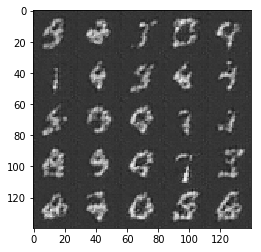

Step 630... Epoch 1/2... Batch 629/937... D Loss: 0.0664... G Loss: 3.5662
Step 645... Epoch 1/2... Batch 644/937... D Loss: 0.3115... G Loss: 1.8440
Step 660... Epoch 1/2... Batch 659/937... D Loss: 0.1500... G Loss: 2.7953
Step 675... Epoch 1/2... Batch 674/937... D Loss: 0.0825... G Loss: 3.0622
Step 690... Epoch 1/2... Batch 689/937... D Loss: 0.0668... G Loss: 3.2553
Step 705... Epoch 1/2... Batch 704/937... D Loss: 0.0896... G Loss: 3.0809
Step 720... Epoch 1/2... Batch 719/937... D Loss: 0.7985... G Loss: 5.2222
Step 735... Epoch 1/2... Batch 734/937... D Loss: 0.2381... G Loss: 2.3852
Step 750... Epoch 1/2... Batch 749/937... D Loss: 0.1608... G Loss: 2.6590
Step 765... Epoch 1/2... Batch 764/937... D Loss: 0.1197... G Loss: 3.1192
Step 780... Epoch 1/2... Batch 779/937... D Loss: 0.1033... G Loss: 3.1866


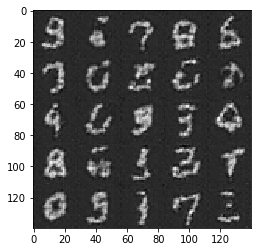

Step 795... Epoch 1/2... Batch 794/937... D Loss: 0.2933... G Loss: 1.6453
Step 810... Epoch 1/2... Batch 809/937... D Loss: 8.2917... G Loss: 14.3234
Step 825... Epoch 1/2... Batch 824/937... D Loss: 0.4185... G Loss: 1.3965
Step 840... Epoch 1/2... Batch 839/937... D Loss: 0.2457... G Loss: 2.0341
Step 855... Epoch 1/2... Batch 854/937... D Loss: 0.1411... G Loss: 3.6508
Step 870... Epoch 1/2... Batch 869/937... D Loss: 0.1502... G Loss: 2.5696
Step 885... Epoch 1/2... Batch 884/937... D Loss: 0.1571... G Loss: 2.3929
Step 900... Epoch 1/2... Batch 899/937... D Loss: 0.1952... G Loss: 2.2055
Step 915... Epoch 1/2... Batch 914/937... D Loss: 0.0836... G Loss: 3.1637
Step 930... Epoch 1/2... Batch 929/937... D Loss: 0.1523... G Loss: 3.6360


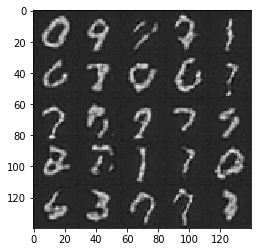

Step 945... Epoch 2/2... Batch 7/937... D Loss: 0.0424... G Loss: 3.9967
Step 960... Epoch 2/2... Batch 22/937... D Loss: 0.0762... G Loss: 3.2287
Step 975... Epoch 2/2... Batch 37/937... D Loss: 0.1870... G Loss: 2.1985
Step 990... Epoch 2/2... Batch 52/937... D Loss: 0.1008... G Loss: 2.8685
Step 1005... Epoch 2/2... Batch 67/937... D Loss: 0.8911... G Loss: 0.9728
Step 1020... Epoch 2/2... Batch 82/937... D Loss: 0.6724... G Loss: 1.3632
Step 1035... Epoch 2/2... Batch 97/937... D Loss: 0.5724... G Loss: 1.4123
Step 1050... Epoch 2/2... Batch 112/937... D Loss: 0.6711... G Loss: 0.9719
Step 1065... Epoch 2/2... Batch 127/937... D Loss: 0.3505... G Loss: 2.1524
Step 1080... Epoch 2/2... Batch 142/937... D Loss: 0.5551... G Loss: 1.1833


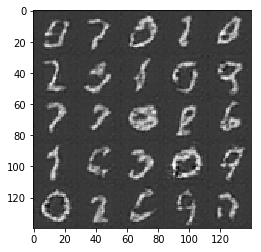

Step 1095... Epoch 2/2... Batch 157/937... D Loss: 0.4867... G Loss: 3.8166
Step 1110... Epoch 2/2... Batch 172/937... D Loss: 0.2919... G Loss: 2.9860
Step 1125... Epoch 2/2... Batch 187/937... D Loss: 1.5946... G Loss: 0.3044
Step 1140... Epoch 2/2... Batch 202/937... D Loss: 0.2697... G Loss: 2.4493
Step 1155... Epoch 2/2... Batch 217/937... D Loss: 0.2592... G Loss: 2.4278
Step 1170... Epoch 2/2... Batch 232/937... D Loss: 0.2156... G Loss: 1.9271
Step 1185... Epoch 2/2... Batch 247/937... D Loss: 0.5244... G Loss: 2.8342
Step 1200... Epoch 2/2... Batch 262/937... D Loss: 1.7205... G Loss: 6.6454
Step 1215... Epoch 2/2... Batch 277/937... D Loss: 0.2745... G Loss: 1.8229
Step 1230... Epoch 2/2... Batch 292/937... D Loss: 0.3286... G Loss: 1.5872
Step 1245... Epoch 2/2... Batch 307/937... D Loss: 0.1384... G Loss: 2.6676


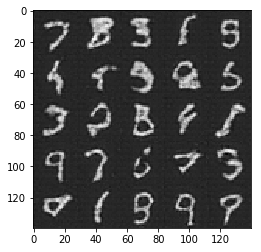

Step 1260... Epoch 2/2... Batch 322/937... D Loss: 0.0605... G Loss: 3.5833
Step 1275... Epoch 2/2... Batch 337/937... D Loss: 0.0813... G Loss: 3.3196
Step 1290... Epoch 2/2... Batch 352/937... D Loss: 1.0471... G Loss: 0.6036
Step 1305... Epoch 2/2... Batch 367/937... D Loss: 0.3541... G Loss: 2.1037
Step 1320... Epoch 2/2... Batch 382/937... D Loss: 0.2542... G Loss: 2.6957
Step 1335... Epoch 2/2... Batch 397/937... D Loss: 0.2516... G Loss: 2.0842
Step 1350... Epoch 2/2... Batch 412/937... D Loss: 0.0790... G Loss: 4.3162
Step 1365... Epoch 2/2... Batch 427/937... D Loss: 0.2335... G Loss: 2.0403
Step 1380... Epoch 2/2... Batch 442/937... D Loss: 0.0685... G Loss: 4.1423
Step 1395... Epoch 2/2... Batch 457/937... D Loss: 0.0561... G Loss: 3.8172


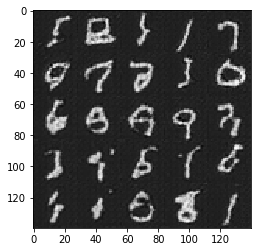

Step 1410... Epoch 2/2... Batch 472/937... D Loss: 0.0381... G Loss: 4.4661
Step 1425... Epoch 2/2... Batch 487/937... D Loss: 8.2438... G Loss: 13.0923
Step 1440... Epoch 2/2... Batch 502/937... D Loss: 3.2085... G Loss: 0.0818
Step 1455... Epoch 2/2... Batch 517/937... D Loss: 0.4918... G Loss: 1.2260
Step 1470... Epoch 2/2... Batch 532/937... D Loss: 0.3453... G Loss: 1.7307
Step 1485... Epoch 2/2... Batch 547/937... D Loss: 0.1378... G Loss: 2.9106
Step 1500... Epoch 2/2... Batch 562/937... D Loss: 1.3572... G Loss: 0.4746
Step 1515... Epoch 2/2... Batch 577/937... D Loss: 0.4698... G Loss: 1.4878
Step 1530... Epoch 2/2... Batch 592/937... D Loss: 0.3789... G Loss: 1.6446
Step 1545... Epoch 2/2... Batch 607/937... D Loss: 0.3098... G Loss: 1.8802
Step 1560... Epoch 2/2... Batch 622/937... D Loss: 0.2587... G Loss: 2.0341


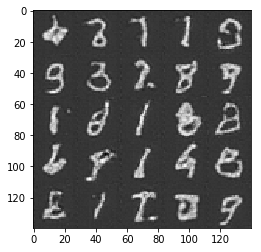

Step 1575... Epoch 2/2... Batch 637/937... D Loss: 0.2258... G Loss: 2.0254
Step 1590... Epoch 2/2... Batch 652/937... D Loss: 0.1250... G Loss: 3.3376
Step 1605... Epoch 2/2... Batch 667/937... D Loss: 0.1500... G Loss: 2.5203
Step 1620... Epoch 2/2... Batch 682/937... D Loss: 0.1239... G Loss: 2.9714
Step 1635... Epoch 2/2... Batch 697/937... D Loss: 0.0677... G Loss: 3.2805
Step 1650... Epoch 2/2... Batch 712/937... D Loss: 0.5567... G Loss: 1.4124
Step 1665... Epoch 2/2... Batch 727/937... D Loss: 0.5519... G Loss: 1.1071
Step 1680... Epoch 2/2... Batch 742/937... D Loss: 0.3084... G Loss: 3.9339
Step 1695... Epoch 2/2... Batch 757/937... D Loss: 0.1778... G Loss: 2.3136
Step 1710... Epoch 2/2... Batch 772/937... D Loss: 0.0349... G Loss: 4.1497


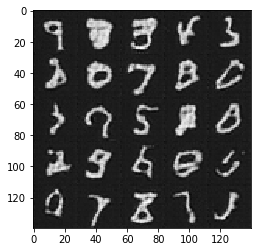

Step 1725... Epoch 2/2... Batch 787/937... D Loss: 0.0755... G Loss: 3.3084
Step 1740... Epoch 2/2... Batch 802/937... D Loss: 0.9743... G Loss: 0.6760
Step 1755... Epoch 2/2... Batch 817/937... D Loss: 0.2547... G Loss: 2.7073
Step 1770... Epoch 2/2... Batch 832/937... D Loss: 1.1294... G Loss: 0.6298
Step 1785... Epoch 2/2... Batch 847/937... D Loss: 0.3867... G Loss: 1.7827
Step 1800... Epoch 2/2... Batch 862/937... D Loss: 0.4363... G Loss: 1.3889
Step 1815... Epoch 2/2... Batch 877/937... D Loss: 0.0766... G Loss: 3.4588
Step 1830... Epoch 2/2... Batch 892/937... D Loss: 0.1000... G Loss: 3.1656
Step 1845... Epoch 2/2... Batch 907/937... D Loss: 0.0933... G Loss: 2.8430
Step 1860... Epoch 2/2... Batch 922/937... D Loss: 0.0369... G Loss: 5.5459


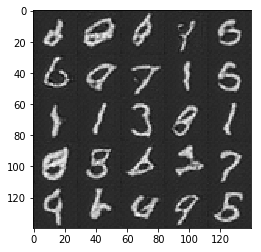

In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
files = glob(os.path.join(data_dir, 'mnist/*.jpg'))
#files = files[:5001]
mnist_dataset = helper.Dataset('mnist', files)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, len(files))

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 15... Epoch 1/1... Batch 14/3165... D Loss: 0.2126... G Loss: 2.1987
Step 30... Epoch 1/1... Batch 29/3165... D Loss: 0.1668... G Loss: 2.6046
Step 45... Epoch 1/1... Batch 44/3165... D Loss: 2.2077... G Loss: 11.5766
Step 60... Epoch 1/1... Batch 59/3165... D Loss: 0.7457... G Loss: 1.3648
Step 75... Epoch 1/1... Batch 74/3165... D Loss: 0.3323... G Loss: 2.8020
Step 90... Epoch 1/1... Batch 89/3165... D Loss: 0.3866... G Loss: 1.8413
Step 105... Epoch 1/1... Batch 104/3165... D Loss: 0.5656... G Loss: 7.6475
Step 120... Epoch 1/1... Batch 119/3165... D Loss: 0.6991... G Loss: 1.1573
Step 135... Epoch 1/1... Batch 134/3165... D Loss: 0.0941... G Loss: 4.2976
Step 150... Epoch 1/1... Batch 149/3165... D Loss: 1.1458... G Loss: 0.5875


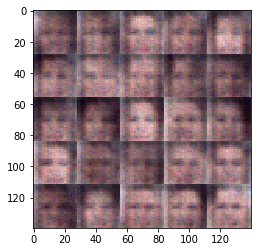

Step 165... Epoch 1/1... Batch 164/3165... D Loss: 0.4476... G Loss: 2.8190
Step 180... Epoch 1/1... Batch 179/3165... D Loss: 0.5556... G Loss: 1.4374
Step 195... Epoch 1/1... Batch 194/3165... D Loss: 0.4116... G Loss: 2.5618
Step 210... Epoch 1/1... Batch 209/3165... D Loss: 0.4533... G Loss: 2.0978
Step 225... Epoch 1/1... Batch 224/3165... D Loss: 0.7750... G Loss: 1.0226
Step 240... Epoch 1/1... Batch 239/3165... D Loss: 0.4694... G Loss: 2.6458
Step 255... Epoch 1/1... Batch 254/3165... D Loss: 0.3780... G Loss: 2.0890
Step 270... Epoch 1/1... Batch 269/3165... D Loss: 0.5052... G Loss: 1.5480
Step 285... Epoch 1/1... Batch 284/3165... D Loss: 0.3157... G Loss: 2.1471
Step 300... Epoch 1/1... Batch 299/3165... D Loss: 0.4326... G Loss: 1.8090


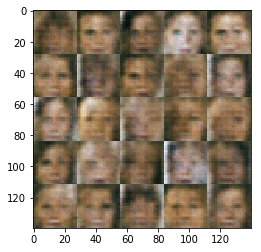

Step 315... Epoch 1/1... Batch 314/3165... D Loss: 0.4586... G Loss: 1.6584
Step 330... Epoch 1/1... Batch 329/3165... D Loss: 0.9509... G Loss: 0.9180
Step 345... Epoch 1/1... Batch 344/3165... D Loss: 0.4628... G Loss: 2.9331
Step 360... Epoch 1/1... Batch 359/3165... D Loss: 0.4868... G Loss: 1.7734
Step 375... Epoch 1/1... Batch 374/3165... D Loss: 0.6539... G Loss: 1.2600
Step 390... Epoch 1/1... Batch 389/3165... D Loss: 0.5115... G Loss: 1.5566
Step 405... Epoch 1/1... Batch 404/3165... D Loss: 0.4108... G Loss: 1.9157
Step 420... Epoch 1/1... Batch 419/3165... D Loss: 0.5243... G Loss: 1.3683
Step 435... Epoch 1/1... Batch 434/3165... D Loss: 0.6653... G Loss: 1.1223
Step 450... Epoch 1/1... Batch 449/3165... D Loss: 0.5789... G Loss: 1.3390
Step 465... Epoch 1/1... Batch 464/3165... D Loss: 0.5308... G Loss: 2.0239


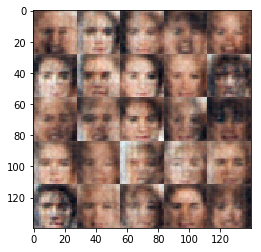

Step 480... Epoch 1/1... Batch 479/3165... D Loss: 0.2725... G Loss: 2.9742
Step 495... Epoch 1/1... Batch 494/3165... D Loss: 0.2695... G Loss: 2.2562
Step 510... Epoch 1/1... Batch 509/3165... D Loss: 0.5579... G Loss: 2.0802
Step 525... Epoch 1/1... Batch 524/3165... D Loss: 0.8419... G Loss: 0.9040
Step 540... Epoch 1/1... Batch 539/3165... D Loss: 2.1148... G Loss: 0.2303
Step 555... Epoch 1/1... Batch 554/3165... D Loss: 0.7023... G Loss: 2.3471
Step 570... Epoch 1/1... Batch 569/3165... D Loss: 0.3903... G Loss: 2.8845
Step 585... Epoch 1/1... Batch 584/3165... D Loss: 0.9906... G Loss: 0.6727
Step 600... Epoch 1/1... Batch 599/3165... D Loss: 0.7277... G Loss: 2.3403
Step 615... Epoch 1/1... Batch 614/3165... D Loss: 0.5365... G Loss: 1.7738


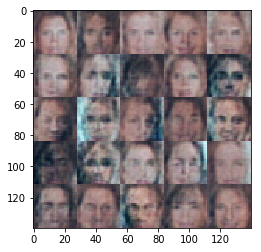

Step 630... Epoch 1/1... Batch 629/3165... D Loss: 0.6554... G Loss: 1.1380
Step 645... Epoch 1/1... Batch 644/3165... D Loss: 0.4801... G Loss: 1.6221
Step 660... Epoch 1/1... Batch 659/3165... D Loss: 0.3619... G Loss: 2.0129
Step 675... Epoch 1/1... Batch 674/3165... D Loss: 0.6899... G Loss: 1.7889
Step 690... Epoch 1/1... Batch 689/3165... D Loss: 0.4445... G Loss: 1.9616
Step 705... Epoch 1/1... Batch 704/3165... D Loss: 0.5027... G Loss: 2.0011
Step 720... Epoch 1/1... Batch 719/3165... D Loss: 0.5708... G Loss: 1.5838
Step 735... Epoch 1/1... Batch 734/3165... D Loss: 0.5482... G Loss: 2.4153
Step 750... Epoch 1/1... Batch 749/3165... D Loss: 0.4959... G Loss: 1.4909
Step 765... Epoch 1/1... Batch 764/3165... D Loss: 0.8716... G Loss: 0.8150
Step 780... Epoch 1/1... Batch 779/3165... D Loss: 0.5118... G Loss: 1.7305


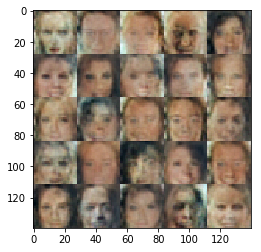

Step 795... Epoch 1/1... Batch 794/3165... D Loss: 0.4855... G Loss: 1.7536
Step 810... Epoch 1/1... Batch 809/3165... D Loss: 1.3778... G Loss: 0.4157
Step 825... Epoch 1/1... Batch 824/3165... D Loss: 0.4764... G Loss: 1.8097
Step 840... Epoch 1/1... Batch 839/3165... D Loss: 0.4298... G Loss: 2.2556
Step 855... Epoch 1/1... Batch 854/3165... D Loss: 0.4449... G Loss: 1.8412
Step 870... Epoch 1/1... Batch 869/3165... D Loss: 0.5660... G Loss: 1.4564
Step 885... Epoch 1/1... Batch 884/3165... D Loss: 0.4958... G Loss: 1.5023
Step 900... Epoch 1/1... Batch 899/3165... D Loss: 0.4242... G Loss: 2.3396
Step 915... Epoch 1/1... Batch 914/3165... D Loss: 0.6253... G Loss: 1.5012
Step 930... Epoch 1/1... Batch 929/3165... D Loss: 0.5917... G Loss: 1.3510


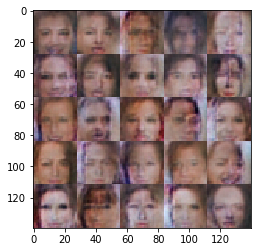

Step 945... Epoch 1/1... Batch 944/3165... D Loss: 0.6341... G Loss: 3.7369
Step 960... Epoch 1/1... Batch 959/3165... D Loss: 0.9362... G Loss: 3.0786
Step 975... Epoch 1/1... Batch 974/3165... D Loss: 0.5580... G Loss: 1.4066
Step 990... Epoch 1/1... Batch 989/3165... D Loss: 0.5325... G Loss: 2.1338
Step 1005... Epoch 1/1... Batch 1004/3165... D Loss: 1.0880... G Loss: 2.8219
Step 1020... Epoch 1/1... Batch 1019/3165... D Loss: 0.5157... G Loss: 2.0533
Step 1035... Epoch 1/1... Batch 1034/3165... D Loss: 0.4153... G Loss: 1.6892
Step 1050... Epoch 1/1... Batch 1049/3165... D Loss: 0.6527... G Loss: 1.0357
Step 1065... Epoch 1/1... Batch 1064/3165... D Loss: 0.7518... G Loss: 0.8945
Step 1080... Epoch 1/1... Batch 1079/3165... D Loss: 0.9888... G Loss: 2.4139


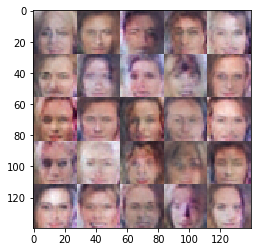

Step 1095... Epoch 1/1... Batch 1094/3165... D Loss: 0.8128... G Loss: 0.8322
Step 1110... Epoch 1/1... Batch 1109/3165... D Loss: 0.5556... G Loss: 1.2607
Step 1125... Epoch 1/1... Batch 1124/3165... D Loss: 0.5094... G Loss: 1.3600
Step 1140... Epoch 1/1... Batch 1139/3165... D Loss: 0.4646... G Loss: 2.0113
Step 1155... Epoch 1/1... Batch 1154/3165... D Loss: 0.4332... G Loss: 2.1761
Step 1170... Epoch 1/1... Batch 1169/3165... D Loss: 0.7284... G Loss: 0.9540
Step 1185... Epoch 1/1... Batch 1184/3165... D Loss: 0.5842... G Loss: 1.2741
Step 1200... Epoch 1/1... Batch 1199/3165... D Loss: 0.5521... G Loss: 1.5804
Step 1215... Epoch 1/1... Batch 1214/3165... D Loss: 0.6805... G Loss: 1.0964
Step 1230... Epoch 1/1... Batch 1229/3165... D Loss: 0.7563... G Loss: 2.3169
Step 1245... Epoch 1/1... Batch 1244/3165... D Loss: 0.4750... G Loss: 1.3372


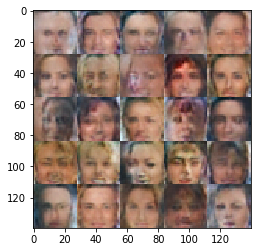

Step 1260... Epoch 1/1... Batch 1259/3165... D Loss: 0.8751... G Loss: 0.8174
Step 1275... Epoch 1/1... Batch 1274/3165... D Loss: 0.4541... G Loss: 1.6163
Step 1290... Epoch 1/1... Batch 1289/3165... D Loss: 0.6738... G Loss: 1.0567
Step 1305... Epoch 1/1... Batch 1304/3165... D Loss: 0.7889... G Loss: 2.7175
Step 1320... Epoch 1/1... Batch 1319/3165... D Loss: 0.5175... G Loss: 1.6909
Step 1335... Epoch 1/1... Batch 1334/3165... D Loss: 0.7763... G Loss: 1.0673
Step 1350... Epoch 1/1... Batch 1349/3165... D Loss: 0.9455... G Loss: 0.6493
Step 1365... Epoch 1/1... Batch 1364/3165... D Loss: 0.6716... G Loss: 1.1554
Step 1380... Epoch 1/1... Batch 1379/3165... D Loss: 0.3888... G Loss: 1.7572
Step 1395... Epoch 1/1... Batch 1394/3165... D Loss: 0.6898... G Loss: 2.8901


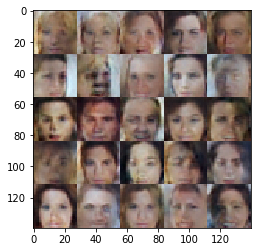

Step 1410... Epoch 1/1... Batch 1409/3165... D Loss: 1.0803... G Loss: 0.5797
Step 1425... Epoch 1/1... Batch 1424/3165... D Loss: 0.5457... G Loss: 1.6157
Step 1440... Epoch 1/1... Batch 1439/3165... D Loss: 1.0385... G Loss: 0.5953
Step 1455... Epoch 1/1... Batch 1454/3165... D Loss: 1.2772... G Loss: 0.4780
Step 1470... Epoch 1/1... Batch 1469/3165... D Loss: 0.7094... G Loss: 1.0981
Step 1485... Epoch 1/1... Batch 1484/3165... D Loss: 0.4673... G Loss: 1.9568
Step 1500... Epoch 1/1... Batch 1499/3165... D Loss: 0.4624... G Loss: 1.4135
Step 1515... Epoch 1/1... Batch 1514/3165... D Loss: 0.7396... G Loss: 0.9927
Step 1530... Epoch 1/1... Batch 1529/3165... D Loss: 0.8613... G Loss: 0.7693
Step 1545... Epoch 1/1... Batch 1544/3165... D Loss: 0.7977... G Loss: 0.8950
Step 1560... Epoch 1/1... Batch 1559/3165... D Loss: 1.3207... G Loss: 0.4442


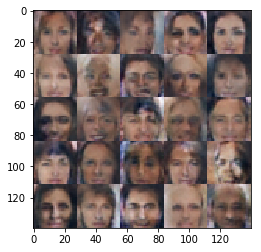

Step 1575... Epoch 1/1... Batch 1574/3165... D Loss: 1.6201... G Loss: 0.3109
Step 1590... Epoch 1/1... Batch 1589/3165... D Loss: 0.5628... G Loss: 1.8761
Step 1605... Epoch 1/1... Batch 1604/3165... D Loss: 0.7084... G Loss: 1.0755
Step 1620... Epoch 1/1... Batch 1619/3165... D Loss: 0.7178... G Loss: 2.4937
Step 1635... Epoch 1/1... Batch 1634/3165... D Loss: 0.8233... G Loss: 2.8425
Step 1650... Epoch 1/1... Batch 1649/3165... D Loss: 0.6877... G Loss: 1.7080
Step 1665... Epoch 1/1... Batch 1664/3165... D Loss: 0.4045... G Loss: 1.7657
Step 1680... Epoch 1/1... Batch 1679/3165... D Loss: 1.8576... G Loss: 4.1390
Step 1695... Epoch 1/1... Batch 1694/3165... D Loss: 0.7304... G Loss: 1.0328
Step 1710... Epoch 1/1... Batch 1709/3165... D Loss: 0.8899... G Loss: 0.7825


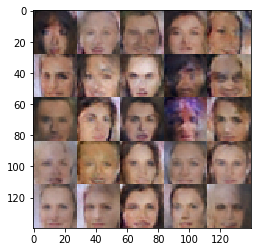

Step 1725... Epoch 1/1... Batch 1724/3165... D Loss: 0.6827... G Loss: 1.3681
Step 1740... Epoch 1/1... Batch 1739/3165... D Loss: 0.3912... G Loss: 2.1640
Step 1755... Epoch 1/1... Batch 1754/3165... D Loss: 0.5099... G Loss: 1.3160
Step 1770... Epoch 1/1... Batch 1769/3165... D Loss: 0.6758... G Loss: 1.1240
Step 1785... Epoch 1/1... Batch 1784/3165... D Loss: 0.9506... G Loss: 0.6886
Step 1800... Epoch 1/1... Batch 1799/3165... D Loss: 0.8822... G Loss: 2.8712
Step 1815... Epoch 1/1... Batch 1814/3165... D Loss: 0.5883... G Loss: 1.2590
Step 1830... Epoch 1/1... Batch 1829/3165... D Loss: 0.4134... G Loss: 1.8873
Step 1845... Epoch 1/1... Batch 1844/3165... D Loss: 0.5428... G Loss: 3.0006
Step 1860... Epoch 1/1... Batch 1859/3165... D Loss: 0.6457... G Loss: 1.8756


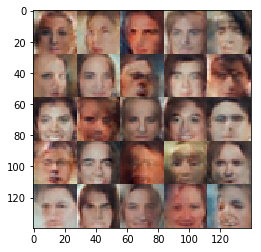

Step 1875... Epoch 1/1... Batch 1874/3165... D Loss: 0.9245... G Loss: 0.7612
Step 1890... Epoch 1/1... Batch 1889/3165... D Loss: 0.7187... G Loss: 2.5506
Step 1905... Epoch 1/1... Batch 1904/3165... D Loss: 1.4588... G Loss: 0.3833
Step 1920... Epoch 1/1... Batch 1919/3165... D Loss: 1.2558... G Loss: 0.5699
Step 1935... Epoch 1/1... Batch 1934/3165... D Loss: 1.0420... G Loss: 0.6045
Step 1950... Epoch 1/1... Batch 1949/3165... D Loss: 0.4715... G Loss: 1.9250
Step 1965... Epoch 1/1... Batch 1964/3165... D Loss: 0.7835... G Loss: 1.7959
Step 1980... Epoch 1/1... Batch 1979/3165... D Loss: 1.5151... G Loss: 0.3986
Step 1995... Epoch 1/1... Batch 1994/3165... D Loss: 1.4306... G Loss: 0.4310
Step 2010... Epoch 1/1... Batch 2009/3165... D Loss: 0.7240... G Loss: 2.0048
Step 2025... Epoch 1/1... Batch 2024/3165... D Loss: 0.5480... G Loss: 2.0367


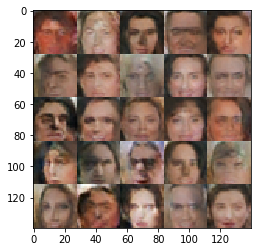

Step 2040... Epoch 1/1... Batch 2039/3165... D Loss: 0.7169... G Loss: 2.1287
Step 2055... Epoch 1/1... Batch 2054/3165... D Loss: 0.5930... G Loss: 1.2980
Step 2070... Epoch 1/1... Batch 2069/3165... D Loss: 0.6060... G Loss: 1.3936
Step 2085... Epoch 1/1... Batch 2084/3165... D Loss: 1.4373... G Loss: 0.3919
Step 2100... Epoch 1/1... Batch 2099/3165... D Loss: 0.9472... G Loss: 2.6784
Step 2115... Epoch 1/1... Batch 2114/3165... D Loss: 0.8717... G Loss: 0.9485
Step 2130... Epoch 1/1... Batch 2129/3165... D Loss: 0.6479... G Loss: 2.0760
Step 2145... Epoch 1/1... Batch 2144/3165... D Loss: 0.6989... G Loss: 1.0428
Step 2160... Epoch 1/1... Batch 2159/3165... D Loss: 1.4414... G Loss: 0.3777
Step 2175... Epoch 1/1... Batch 2174/3165... D Loss: 0.9394... G Loss: 0.8372


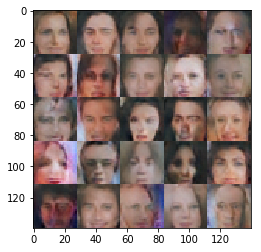

Step 2190... Epoch 1/1... Batch 2189/3165... D Loss: 0.7015... G Loss: 1.2660
Step 2205... Epoch 1/1... Batch 2204/3165... D Loss: 0.6977... G Loss: 1.3992
Step 2220... Epoch 1/1... Batch 2219/3165... D Loss: 0.6565... G Loss: 1.3167
Step 2235... Epoch 1/1... Batch 2234/3165... D Loss: 0.9093... G Loss: 0.8035
Step 2250... Epoch 1/1... Batch 2249/3165... D Loss: 0.5860... G Loss: 1.4457
Step 2265... Epoch 1/1... Batch 2264/3165... D Loss: 2.6556... G Loss: 5.6904
Step 2280... Epoch 1/1... Batch 2279/3165... D Loss: 0.7619... G Loss: 1.0380
Step 2295... Epoch 1/1... Batch 2294/3165... D Loss: 0.6958... G Loss: 1.8554
Step 2310... Epoch 1/1... Batch 2309/3165... D Loss: 0.6047... G Loss: 1.8181
Step 2325... Epoch 1/1... Batch 2324/3165... D Loss: 0.6038... G Loss: 1.6045
Step 2340... Epoch 1/1... Batch 2339/3165... D Loss: 0.8640... G Loss: 0.7911


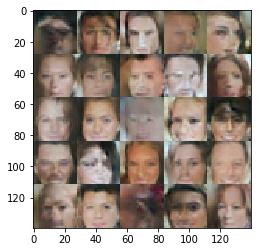

Step 2355... Epoch 1/1... Batch 2354/3165... D Loss: 0.8704... G Loss: 0.9027
Step 2370... Epoch 1/1... Batch 2369/3165... D Loss: 0.5268... G Loss: 2.6928
Step 2385... Epoch 1/1... Batch 2384/3165... D Loss: 0.7025... G Loss: 1.3763
Step 2400... Epoch 1/1... Batch 2399/3165... D Loss: 0.6109... G Loss: 1.2187
Step 2415... Epoch 1/1... Batch 2414/3165... D Loss: 1.2896... G Loss: 0.4504
Step 2430... Epoch 1/1... Batch 2429/3165... D Loss: 0.7578... G Loss: 1.5644
Step 2445... Epoch 1/1... Batch 2444/3165... D Loss: 0.5695... G Loss: 1.8308
Step 2460... Epoch 1/1... Batch 2459/3165... D Loss: 0.5277... G Loss: 1.4313
Step 2475... Epoch 1/1... Batch 2474/3165... D Loss: 0.6341... G Loss: 1.4679
Step 2490... Epoch 1/1... Batch 2489/3165... D Loss: 1.0494... G Loss: 0.6457


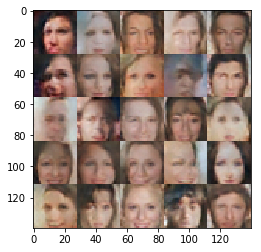

Step 2505... Epoch 1/1... Batch 2504/3165... D Loss: 0.7569... G Loss: 0.9933
Step 2520... Epoch 1/1... Batch 2519/3165... D Loss: 0.6446... G Loss: 1.7204
Step 2535... Epoch 1/1... Batch 2534/3165... D Loss: 0.7855... G Loss: 0.8368
Step 2550... Epoch 1/1... Batch 2549/3165... D Loss: 0.8751... G Loss: 0.8755
Step 2565... Epoch 1/1... Batch 2564/3165... D Loss: 0.7096... G Loss: 0.9835
Step 2580... Epoch 1/1... Batch 2579/3165... D Loss: 0.8158... G Loss: 0.9834
Step 2595... Epoch 1/1... Batch 2594/3165... D Loss: 0.6189... G Loss: 1.4987
Step 2610... Epoch 1/1... Batch 2609/3165... D Loss: 0.7619... G Loss: 0.9777
Step 2625... Epoch 1/1... Batch 2624/3165... D Loss: 0.7479... G Loss: 1.0122
Step 2640... Epoch 1/1... Batch 2639/3165... D Loss: 0.7924... G Loss: 1.0165


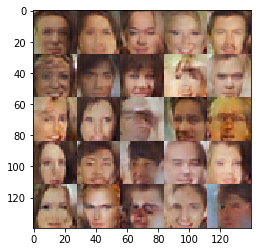

Step 2655... Epoch 1/1... Batch 2654/3165... D Loss: 0.8029... G Loss: 0.8747
Step 2670... Epoch 1/1... Batch 2669/3165... D Loss: 0.5981... G Loss: 1.8859
Step 2685... Epoch 1/1... Batch 2684/3165... D Loss: 0.6384... G Loss: 1.5207
Step 2700... Epoch 1/1... Batch 2699/3165... D Loss: 0.7546... G Loss: 1.4648
Step 2715... Epoch 1/1... Batch 2714/3165... D Loss: 0.7196... G Loss: 1.0556
Step 2730... Epoch 1/1... Batch 2729/3165... D Loss: 1.2842... G Loss: 1.8723
Step 2745... Epoch 1/1... Batch 2744/3165... D Loss: 0.6752... G Loss: 1.5472
Step 2760... Epoch 1/1... Batch 2759/3165... D Loss: 1.0676... G Loss: 0.6929
Step 2775... Epoch 1/1... Batch 2774/3165... D Loss: 0.6680... G Loss: 1.1671
Step 2790... Epoch 1/1... Batch 2789/3165... D Loss: 0.6465... G Loss: 1.5213
Step 2805... Epoch 1/1... Batch 2804/3165... D Loss: 0.6039... G Loss: 1.8226


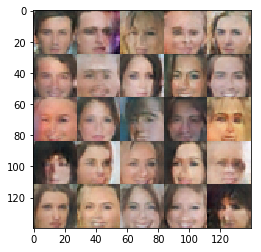

Step 2820... Epoch 1/1... Batch 2819/3165... D Loss: 1.2391... G Loss: 1.6550
Step 2835... Epoch 1/1... Batch 2834/3165... D Loss: 0.7821... G Loss: 1.0568
Step 2850... Epoch 1/1... Batch 2849/3165... D Loss: 1.0351... G Loss: 0.6441
Step 2865... Epoch 1/1... Batch 2864/3165... D Loss: 0.7631... G Loss: 2.2623
Step 2880... Epoch 1/1... Batch 2879/3165... D Loss: 0.9234... G Loss: 1.0141
Step 2895... Epoch 1/1... Batch 2894/3165... D Loss: 0.7319... G Loss: 1.0592
Step 2910... Epoch 1/1... Batch 2909/3165... D Loss: 0.7943... G Loss: 1.1170
Step 2925... Epoch 1/1... Batch 2924/3165... D Loss: 1.5421... G Loss: 0.3885
Step 2940... Epoch 1/1... Batch 2939/3165... D Loss: 0.6664... G Loss: 1.0394
Step 2955... Epoch 1/1... Batch 2954/3165... D Loss: 0.7815... G Loss: 0.9642


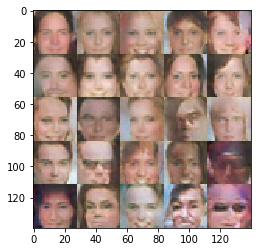

Step 2970... Epoch 1/1... Batch 2969/3165... D Loss: 0.5336... G Loss: 1.4804
Step 2985... Epoch 1/1... Batch 2984/3165... D Loss: 0.8107... G Loss: 1.7023
Step 3000... Epoch 1/1... Batch 2999/3165... D Loss: 0.7349... G Loss: 1.1162
Step 3015... Epoch 1/1... Batch 3014/3165... D Loss: 1.3792... G Loss: 0.4070
Step 3030... Epoch 1/1... Batch 3029/3165... D Loss: 0.5680... G Loss: 1.9463
Step 3045... Epoch 1/1... Batch 3044/3165... D Loss: 0.7192... G Loss: 1.6366
Step 3060... Epoch 1/1... Batch 3059/3165... D Loss: 0.7636... G Loss: 1.1259
Step 3075... Epoch 1/1... Batch 3074/3165... D Loss: 1.1941... G Loss: 0.6005
Step 3090... Epoch 1/1... Batch 3089/3165... D Loss: 0.6891... G Loss: 1.0358


In [ ]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

files = glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))
celeba_dataset = helper.Dataset('celeba', files)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, len(files))

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.